In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

features_file = '/content/features.txt'
X_train_file = '/content/X_train.txt'
y_train_file = '/content/y_train.txt'
with open(features_file, 'r') as f:
    feature_names = f.read().splitlines()

X_train = pd.read_csv(X_train_file, sep='\s+', names=feature_names)
y_train = pd.read_csv(y_train_file, sep='\s+', names=['activity'])

## Task 1: Use K-Means and DBSCAN to do clustering on the given dataset

### K-Means Clustering

In [3]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Standardising the data.
X_train_std = StandardScaler().fit_transform(X_train)

inertias = []
silhouette_scores = []
db_scores = []
K_range = range(1, 10)  # Adjust the range based on your dataset

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=11, n_init='auto').fit(X_train_std)
    inertias.append(kmeans.inertia_)
    if(k != 1):
      silhouette_scores.append(silhouette_score(X_train_std, kmeans.labels_))
      db_scores.append(davies_bouldin_score(X_train_std, kmeans.labels_))


#### Inertia plot for finding the elbow

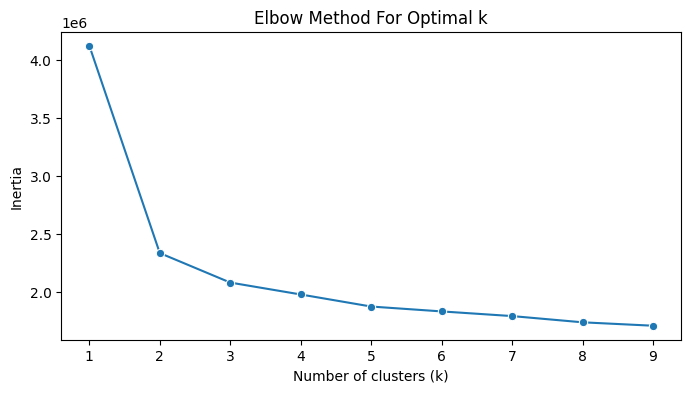

In [4]:
elbow_data = pd.DataFrame({
    'Number of clusters (k)': list(K_range),
    'Inertia': inertias
    })

plt.figure(figsize=(8, 4))
sns.lineplot(x='Number of clusters (k)', y='Inertia', data=elbow_data, marker="o")
plt.title('Elbow Method For Optimal k')
plt.show()

Optimal k value appears to be 2

#### Sihouette Scores plot

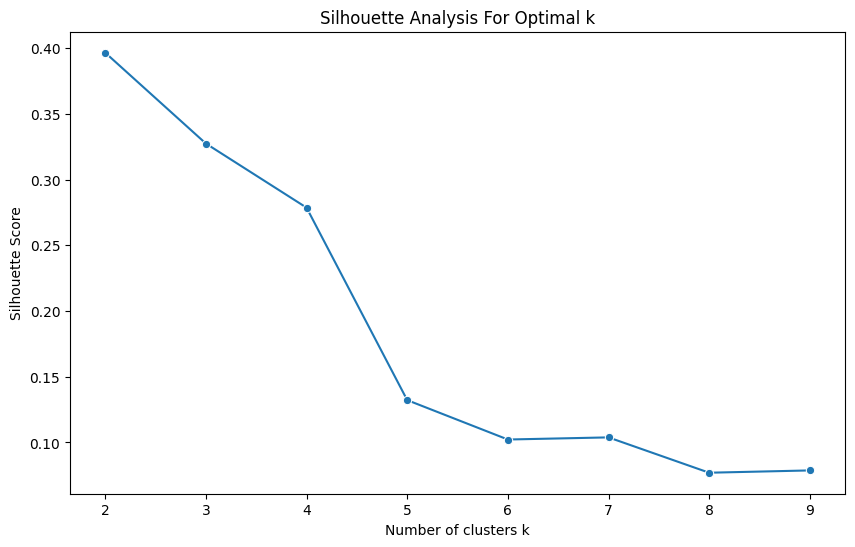

In [5]:
silhouette_data = pd.DataFrame({
    'Number of clusters k': list(range(2, 10)),
    'Silhouette Score': silhouette_scores
    })

plt.figure(figsize=(10, 6))
sns_plot = sns.lineplot(x='Number of clusters k', y='Silhouette Score', data=silhouette_data, marker='o')
sns_plot.set_title('Silhouette Analysis For Optimal k')
plt.show()

Here, k = 2 has highest silhouette score.

#### Davies-Bouldin index plot

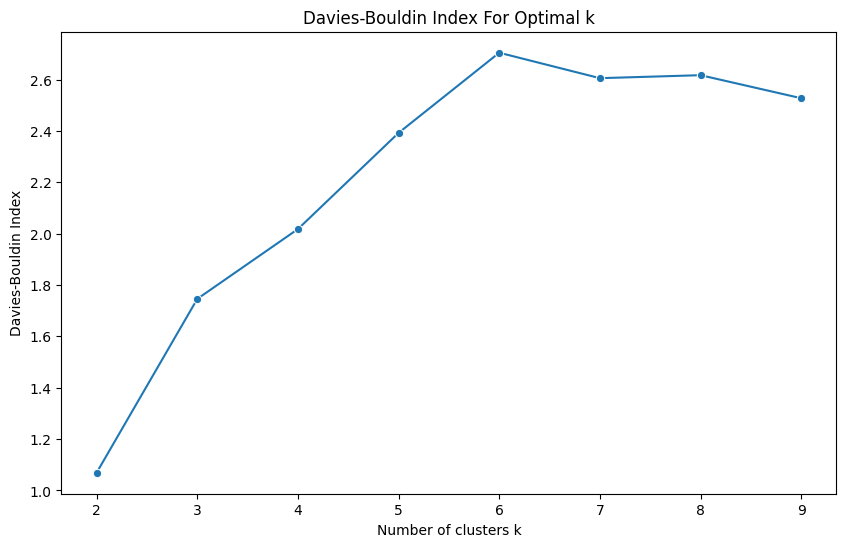

In [6]:
db_data = pd.DataFrame({
    'Number of clusters k': list(range(2, 10)),
    'Davies-Bouldin Index': db_scores
    })

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns_plot = sns.lineplot(x='Number of clusters k', y='Davies-Bouldin Index', data=db_data, marker='o')
sns_plot.set_title('Davies-Bouldin Index For Optimal k')
plt.show()

As we can see that minimum Davies-Bouldin index is for k = 2.

From all the three scores, we can conclude that optimal k = 2.

### DBSCAN

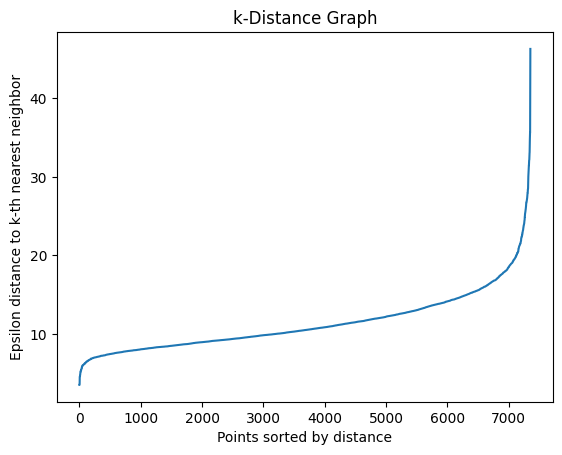

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np


# Use NearestNeighbors to find the distance to the k-th nearest neighbor
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_std)
distances, indices = nbrs.kneighbors(X_train_std)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon distance to k-th nearest neighbor')
plt.show()


Best eps appears to be 20

In [8]:
eps_value = 20

# Choose a 'min_samples' value after considering dataset density
min_samples_value = len(feature_names)

# Perform DBSCAN clustering with the chosen 'eps' and 'min_samples'
db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X_train_std)

labels = db.labels_
# Number of clusters in labels, ignoring noise if present
print(f'DBSCAN clusters: {len(set(labels)) - (1 if -1 in labels else 0)}')

DBSCAN clusters: 1


## Task 2: Use a dimensionality reduction technique before using K-Means and DBSCAN on the dataset.

In [9]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=923b69936d616d2a3d1d1259cb1f5dcaf88f2dc3e05cbab140b005cf9a7ce190
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# PCA
pca = PCA(n_components=2, svd_solver = 'full', random_state=11)
X_pca = pca.fit_transform(X_train_std)

# t-SNE
tsne = TSNE(n_components=2, random_state=11)
X_tsne = tsne.fit_transform(X_train_std)

# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=11)
X_umap = umap_reducer.fit_transform(X_train_std)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Timing the K-means and DBSCAN without and with dimensionality reduction

In [16]:
%%time
km_model = KMeans(n_clusters=2, random_state=11, n_init='auto').fit(X_train_std)


CPU times: user 255 ms, sys: 109 ms, total: 364 ms
Wall time: 210 ms


In [17]:
%%time
km_model_pca = KMeans(n_clusters=2, random_state=11, n_init='auto').fit(X_pca)

CPU times: user 109 ms, sys: 71.8 ms, total: 181 ms
Wall time: 107 ms


In [18]:
%%time
km_model_tsne = KMeans(n_clusters=2, random_state=11, n_init='auto').fit(X_tsne)

CPU times: user 109 ms, sys: 1.95 ms, total: 111 ms
Wall time: 121 ms


In [19]:
%%time
km_model_umap = KMeans(n_clusters=2, random_state=11, n_init='auto').fit(X_umap)

CPU times: user 6.85 ms, sys: 0 ns, total: 6.85 ms
Wall time: 5.79 ms


In [20]:
%%time
db_model = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X_train_std)

CPU times: user 4.45 s, sys: 137 ms, total: 4.59 s
Wall time: 2.54 s


In [21]:
%%time
db_model_pca = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X_pca)

CPU times: user 934 ms, sys: 214 ms, total: 1.15 s
Wall time: 731 ms


In [22]:
%%time
db_model_tsne = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X_tsne)

CPU times: user 139 ms, sys: 978 µs, total: 140 ms
Wall time: 141 ms


In [23]:
%%time
db_model_umap = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X_umap)

CPU times: user 633 ms, sys: 532 ms, total: 1.17 s
Wall time: 1.19 s


## Task 3 – Visualize the clusters

### KMeans clusters

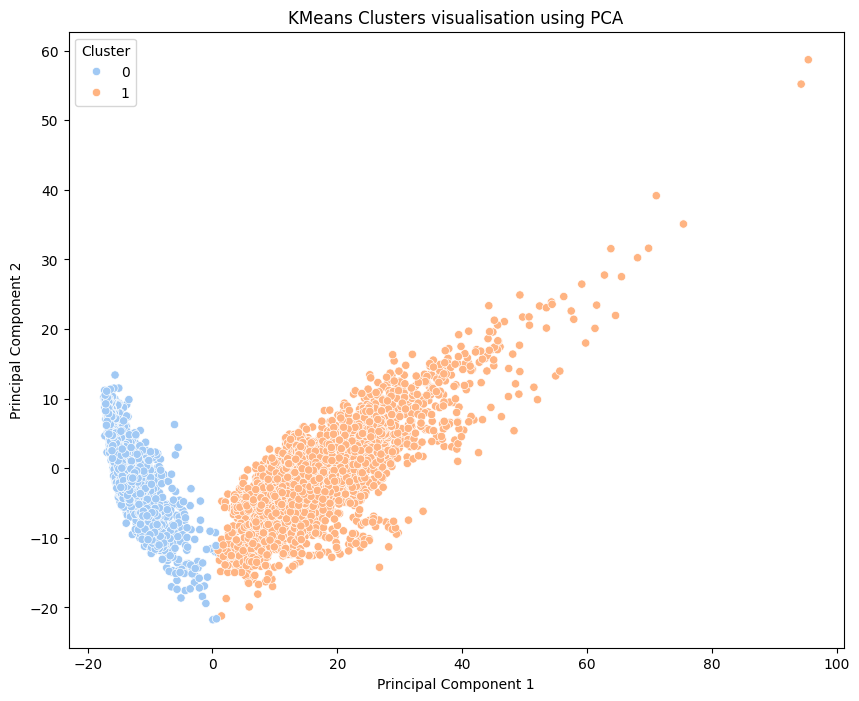

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_plotting = pd.DataFrame(X_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_plotting['Cluster'] = km_model_pca.labels_

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=df_plotting, palette='pastel')
plt.title('KMeans Clusters visualisation using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


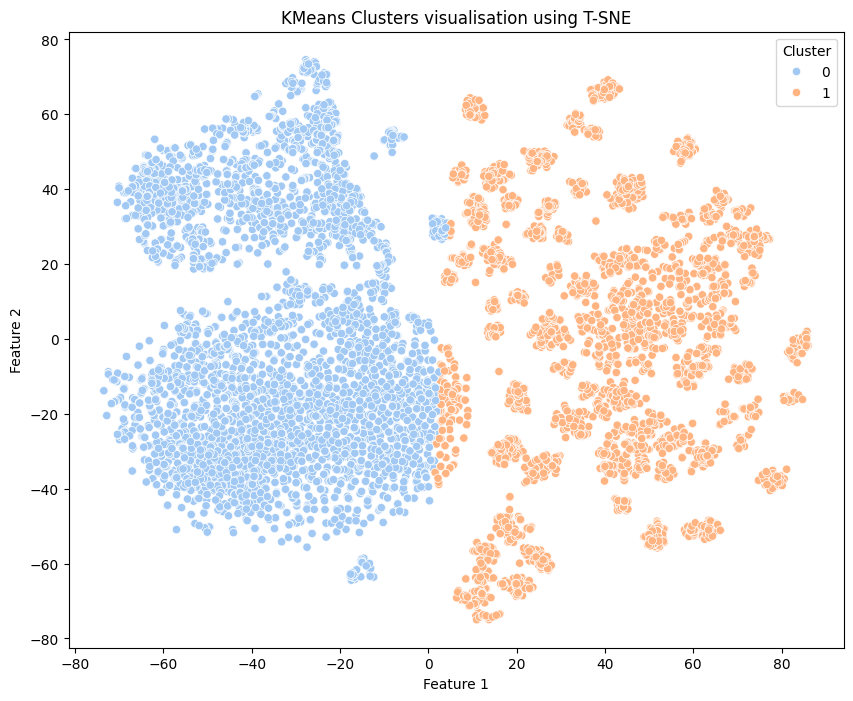

In [25]:
df_plotting = pd.DataFrame(X_tsne, columns=['Feature 1', 'Feature 2'])
df_plotting['Cluster'] = km_model_tsne.labels_

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Feature 1', y='Feature 2', hue='Cluster', data=df_plotting, palette='pastel')
plt.title('KMeans Clusters visualisation using T-SNE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()


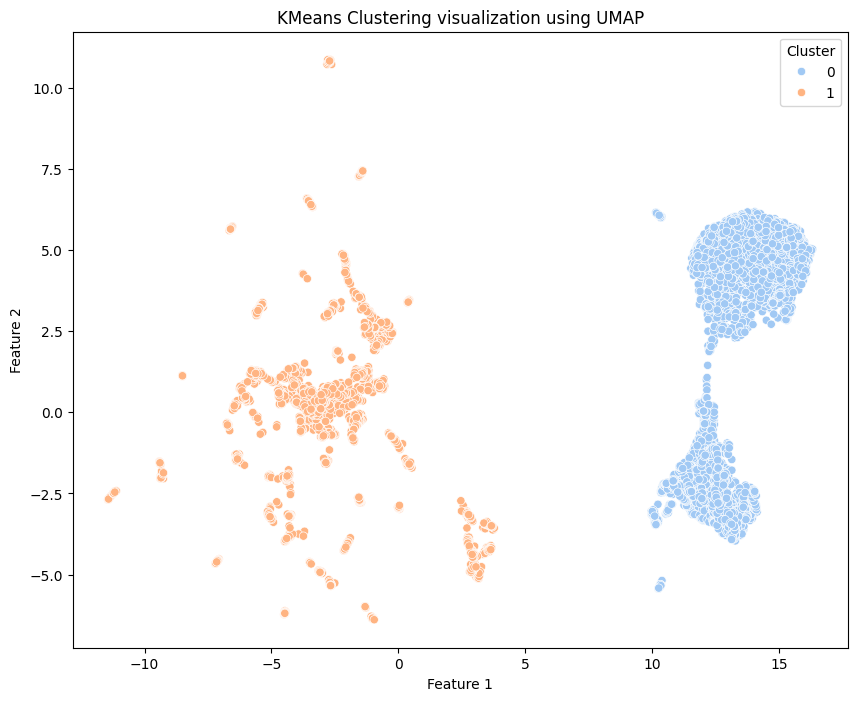

In [26]:
df_plotting = pd.DataFrame(X_umap, columns=['Feature 1', 'Feature 2'])
df_plotting['Cluster'] = km_model_umap.labels_

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Feature 1', y='Feature 2', hue='Cluster', data=df_plotting, palette='pastel')
plt.title('KMeans Clustering visualization using UMAP')
plt.legend(title='Cluster')
plt.show()


### DBSCAN clusters

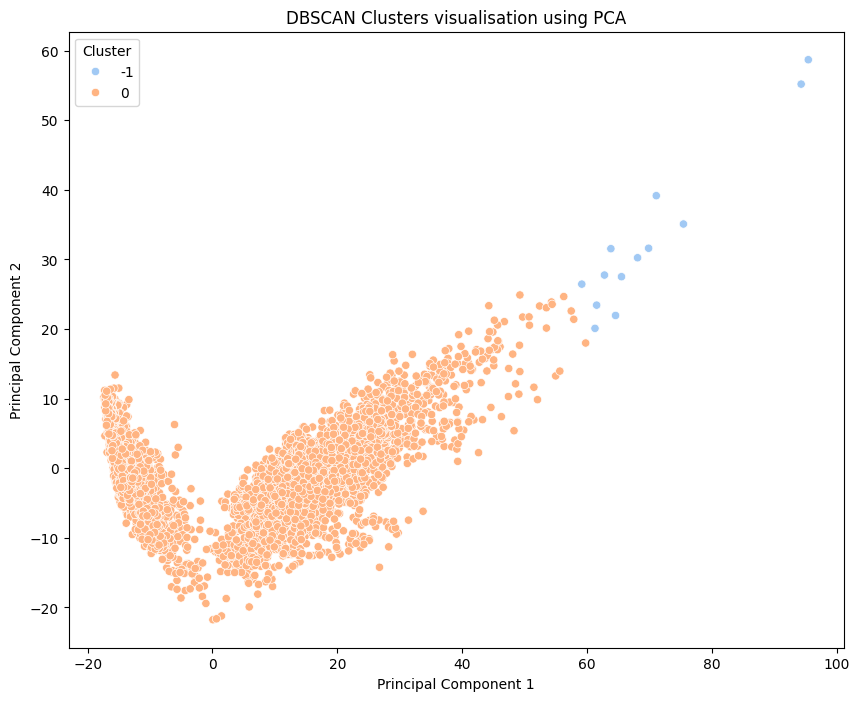

In [22]:
df_plotting = pd.DataFrame(X_pca, columns=['Principal Component 1', 'Principal Component 2'])
df_plotting['Cluster'] = db_model_pca.labels_

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=df_plotting, palette='pastel')
plt.title('DBSCAN Clusters visualisation using PCA')
plt.legend(title='Cluster')
plt.show()


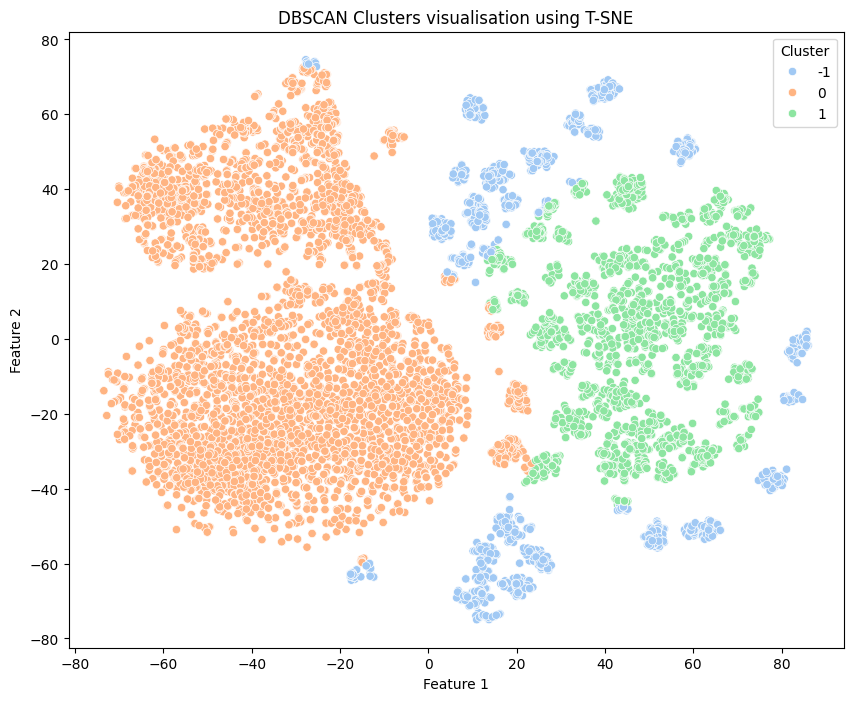

In [23]:
df_plotting = pd.DataFrame(X_tsne, columns=['Feature 1', 'Feature 2'])
df_plotting['Cluster'] = db_model_tsne.labels_

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Feature 1', y='Feature 2', hue='Cluster', data=df_plotting, palette='pastel')
plt.title('DBSCAN Clusters visualisation using T-SNE')
plt.legend(title='Cluster')
plt.show()


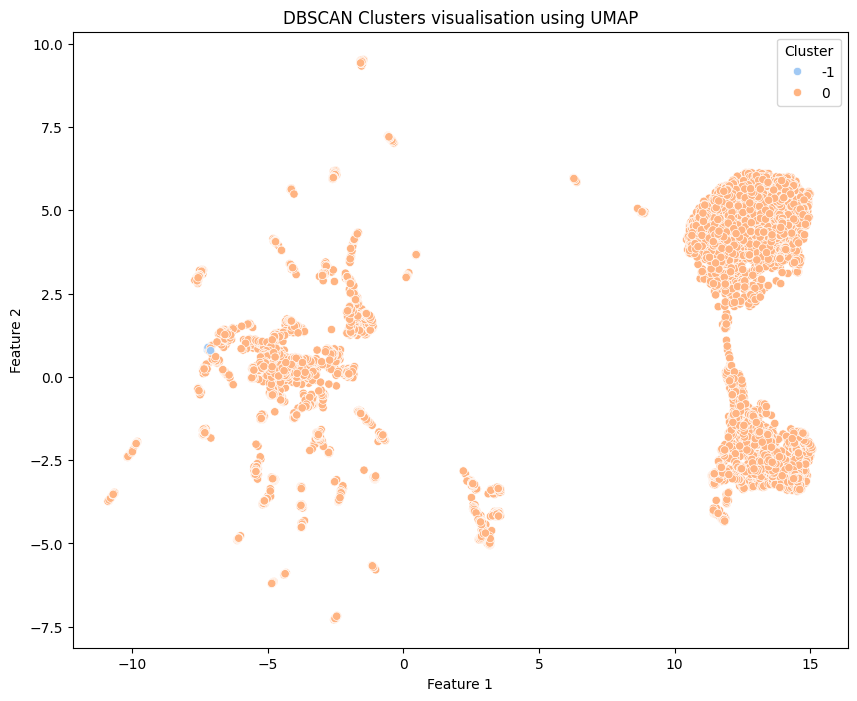

In [24]:
df_plotting = pd.DataFrame(X_umap, columns=['Feature 1', 'Feature 2'])
df_plotting['Cluster'] = db_model_pca.labels_

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Feature 1', y='Feature 2', hue='Cluster', data=df_plotting, palette='pastel')
plt.title('DBSCAN Clusters visualisation using UMAP')
plt.legend(title='Cluster')
plt.show()
